# The MS COCO classification challenge

Razmig Kéchichian

This notebook defines the multi-class classification challenge on the [MS COCO dataset](https://cocodataset.org/). It defines the problem, sets the rules of organization and presents tools you are provided with to accomplish the challenge.


## 1. Problem statement

Each image has **several** categories of objects to predict, hence the difference compared to the classification problem we have seen on the CIFAR10 dataset where each image belonged to a **single** category, therefore the network loss function and prediction mechanism (only highest output probability) were defined taking this constraint into account.

We adapted the MS COCO dataset for the requirements of this challenge by, among other things, reducing the number of images and their dimensions to facilitate processing.

In the companion `ms-coco.zip` compressed directory you will find two sub-directories:
- `images`: which contains the images in train (65k) and test (~5k) subsets,
- `labels`: which lists labels for each of the images in the train subset only.

Each label file gives a list of class IDs that correspond to the class index in the following tuple:

In [1]:
classes = ("person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
           "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
           "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",       
           "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
           "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
           "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", 
           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", 
           "hair drier", "toothbrush")

Your goal is to follow a **transfer learning strategy** in training and validating a network on **your own distribution of training data into training and a validation subsets**, then to **test it on the test subset** by producing a [JSON file](https://en.wikipedia.org/wiki/JSON) with content of the following format:

```
{
    "000000000139": [
        56,
        60,
        62
    ],
    "000000000285": [
        21,
    ],
    "000000000632": [
        57,
        59,
    73
    ],
    # other test images
}
```

In this file, the name (without extension) of each test image is associated with a list of class indices predicted by your network. Make sure that the JSON file you produce **follows this format strictly**.

You will submit your JSON prediction file to the following [online evaluation server and leaderboard](https://www.creatis.insa-lyon.fr/kechichian/ms-coco-classif-leaderboard.html), which will evaluate your predictions on test set labels, unavailable to you.

<div class="alert alert-block alert-danger"> <b>WARNING:</b> Use this server with <b>the greatest care</b>. A new submission with identical Participant or group name will <b>overwrite</b> the identically named submission, if one already exists, therefore check the leaderboard first. <b>Do not make duplicate leaderboard entries for your group</b>, keep track of your test scores privately. Also pay attention to upload only JSON files of the required format.<br>
</div>

The evaluation server calculates and returns mean performances over all classes, and optionally per class performances. Entries in the leaderboard are sorted by the F1 metric.

You can request an evaluation as many times as you want. It is up to you to specify the final evaluation by updating the leaderboard entry corresponding to your Participant or group name. This entry will be taken into account for grading your work.

It goes without saying that it is **prohibited** to use another distribution of the MS COCO database for training, e.g. the Torchvision dataset.


## 2. Organization

- Given the scope of the project, you will work in groups of 2. 
- Work on the challenge begins on IAV lab 3 session, that is on the **23rd of September**.
- Results are due 10 days later, that is on the **3rd of October, 18:00**. They comrpise:
    - a submission to the leaderboard,
    - a commented Python script (with any necessary modules) or Jupyter Notebook, uploaded on Moodle in the challenge repository by one of the members of the group.
    
    
## 3. Tools

In addition to the MS COCO annotated data and the evaluation server, we provide you with most code building blocks. Your task is to understand them and use them to create the glue logic, that is the main program, putting all these blocks together and completing them as necessary to implement a complete machine learning workflow to train and validate a model, and produce the test JSON file.

### 3.1 Custom `Dataset`s

We provide you with two custom `torch.utils.data.Dataset` sub-classes to use in training and testing.

In [2]:
import os
from glob import glob
from pathlib import Path

from PIL import Image
import torch


class COCOTrainImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, annotations_dir, max_images=None, transform=None):
        self.img_labels = sorted(glob("*.cls", root_dir=annotations_dir))
        if max_images:
            self.img_labels = self.img_labels[:max_images]
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, Path(self.img_labels[idx]).stem + ".jpg")
        labels_path = os.path.join(self.annotations_dir, self.img_labels[idx])
       
        image = Image.open(img_path).convert("RGB")
        with open(labels_path) as f: 
            labels = [int(label) for label in f.readlines()]
        if self.transform:
            image = self.transform(image)
        labels = torch.zeros(80).scatter_(0, torch.tensor(labels), value=1)
        return image, labels


class COCOTestImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_list = sorted(glob("*.jpg", root_dir=img_dir))    
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_path).convert("RGB")        
        if self.transform:
            image = self.transform(image)
        return image, Path(img_path).stem # filename w/o extension

### 3.2 Training and validation loops

The following are two general-purpose classification train and validation loop functions to be called inside the epochs for-loop with appropriate argument settings.

Pay particular attention to the `validation_loop()` function's arguments `multi_task`, `th_multi_task` and `one_hot`.

In [3]:
import torch


def train_loop(train_loader, net, criterion, optimizer, device,
               mbatch_loss_group=-1):
    net.train()
    running_loss = 0.0
    mbatch_losses = []
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # following condition False by default, unless mbatch_loss_group > 0
        if i % mbatch_loss_group == mbatch_loss_group - 1:
            mbatch_losses.append(running_loss / mbatch_loss_group)
            running_loss = 0.0
    if mbatch_loss_group > 0:
        return mbatch_losses


def validation_loop(val_loader, net, criterion, num_classes, device,
                    multi_task=False, th_multi_task=0.5, one_hot=False, class_metrics=False):
    net.eval()
    loss = 0
    correct = 0
    size = len(val_loader.dataset)
    class_total = {label:0 for label in range(num_classes)}
    class_tp = {label:0 for label in range(num_classes)}
    class_fp = {label:0 for label in range(num_classes)}
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            if not multi_task:    
                predictions = torch.zeros_like(outputs)
                predictions[torch.arange(outputs.shape[0]), torch.argmax(outputs, dim=1)] = 1.0
            else:
                predictions = torch.where(outputs > th_multi_task, 1.0, 0.0)
            if not one_hot:
                labels_mat = torch.zeros_like(outputs)
                labels_mat[torch.arange(outputs.shape[0]), labels] = 1.0
                labels = labels_mat
                
            tps = predictions * labels
            fps = predictions - tps
            
            tps = tps.sum(dim=0)
            fps = fps.sum(dim=0)
            lbls = labels.sum(dim=0)  
                
            for c in range(num_classes):
                class_tp[c] += tps[c]
                class_fp[c] += fps[c]
                class_total[c] += lbls[c]
                    
            correct += tps.sum()

    class_prec = []
    class_recall = []
    freqs = []
    for c in range(num_classes):
        class_prec.append(0 if class_tp[c] == 0 else
                          class_tp[c] / (class_tp[c] + class_fp[c]))
        class_recall.append(0 if class_tp[c] == 0 else
                            class_tp[c] / class_total[c])
        freqs.append(class_total[c])

    freqs = torch.tensor(freqs)
    class_weights = 1. / freqs
    class_weights /= class_weights.sum()
    class_prec = torch.tensor(class_prec)
    class_recall = torch.tensor(class_recall)
    prec = (class_prec * class_weights).sum()
    recall = (class_recall * class_weights).sum()
    f1 = 2. / (1/prec + 1/recall)
    val_loss = loss / size
    accuracy = correct / freqs.sum()
    results = {"loss": val_loss, "accuracy": accuracy, "f1": f1,\
               "precision": prec, "recall": recall}

    if class_metrics:
        class_results = []
        for p, r in zip(class_prec, class_recall):
            f1 = (0 if p == r == 0 else 2. / (1/p + 1/r))
            class_results.append({"f1": f1, "precision": p, "recall": r})
        results = results, class_results

    return results

### 3.3 Tensorboard logging (optional)

Evaluation metrics and losses produced by the `validation_loop()` function on train and validation data can be logged to a [Tensorboard `SummaryWriter`](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) which allows you to observe training graphically via the following function:

In [4]:
def update_graphs(summary_writer, epoch, train_results, test_results,
                  train_class_results=None, test_class_results=None, 
                  class_names = None, mbatch_group=-1, mbatch_count=0, mbatch_losses=None):
    if mbatch_group > 0:
        for i in range(len(mbatch_losses)):
            summary_writer.add_scalar("Losses/Train mini-batches",
                                  mbatch_losses[i],
                                  epoch * mbatch_count + (i+1)*mbatch_group)

    summary_writer.add_scalars("Losses/Train Loss vs Test Loss",
                               {"Train Loss" : train_results["loss"],
                                "Test Loss" : test_results["loss"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Accuracy vs Test Accuracy",
                               {"Train Accuracy" : train_results["accuracy"],
                                "Test Accuracy" : test_results["accuracy"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train F1 vs Test F1",
                               {"Train F1" : train_results["f1"],
                                "Test F1" : test_results["f1"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Precision vs Test Precision",
                               {"Train Precision" : train_results["precision"],
                                "Test Precision" : test_results["precision"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Recall vs Test Recall",
                               {"Train Recall" : train_results["recall"],
                                "Test Recall" : test_results["recall"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    if train_class_results and test_class_results:
        for i in range(len(train_class_results)):
            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train F1 vs Test F1",
                                       {"Train F1" : train_class_results[i]["f1"],
                                        "Test F1" : test_class_results[i]["f1"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)

            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train Precision vs Test Precision",
                                       {"Train Precision" : train_class_results[i]["precision"],
                                        "Test Precision" : test_class_results[i]["precision"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)

            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train Recall vs Test Recall",
                                       {"Train Recall" : train_class_results[i]["recall"],
                                        "Test Recall" : test_class_results[i]["recall"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)
    summary_writer.flush()

## 4. The skeleton of the model training and validation program

Your main program should have more or less the following sections and control flow:

<b>RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1</b>

<div class="alert alert-block alert-warning"> Test du modele
</div>

In [6]:
from torchvision.models import regnet_y_16gf, RegNet_Y_16GF_Weights
from torchinfo import summary

model = regnet_y_16gf(weights=RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
for param in model.parameters() :
    param.requires_grad = False
model.fc = torch.nn.Sequential(
    torch.nn.Linear(3024, 80),
    torch.nn.Sigmoid()  # Assuming multi-label classification
)
print(model)
summary(model, input_size=(1, 3, 224, 149))

Downloading: "https://download.pytorch.org/models/regnet_y_16gf_swag-43afe44d.pth" to C:\Users\kergu/.cache\torch\hub\checkpoints\regnet_y_16gf_swag-43afe44d.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319M/319M [00:29<00:00, 11.3MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

Layer (type:depth-idx)                                  Output Shape              Param #
RegNet                                                  [1, 80]                   --
├─SimpleStemIN: 1-1                                     [1, 32, 112, 75]          --
│    └─Conv2d: 2-1                                      [1, 32, 112, 75]          (864)
│    └─BatchNorm2d: 2-2                                 [1, 32, 112, 75]          (64)
│    └─ReLU: 2-3                                        [1, 32, 112, 75]          --
├─Sequential: 1-2                                       [1, 3024, 7, 5]           --
│    └─AnyStage: 2-4                                    [1, 224, 56, 38]          --
│    │    └─ResBottleneckBlock: 3-1                     [1, 224, 56, 38]          (295,912)
│    │    └─ResBottleneckBlock: 3-2                     [1, 224, 56, 38]          (352,856)
│    └─AnyStage: 2-5                                    [1, 448, 28, 19]          --
│    │    └─ResBottleneckBlock: 3-3      

<div class="alert alert-block alert-warning"> Test des dataloaders
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Aa
ga
Ba
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


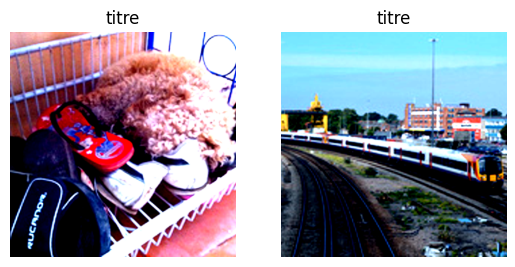

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import RegNet_Y_16GF_Weights

def imshow(ax, img, title):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0))) # NumPy expects (W, H, C)
    ax.set_title(title)
    ax.axis("off")

classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
           "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
           "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",       
           "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
           "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
           "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", 
           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", 
           "hair drier", "toothbrush"]
minibatch_size = 2

# data directories initialization
train_dir = "./ms-coco/images/train-resized"
annotation_dir = "./ms-coco/labels/train"
test_dir = "./ms-coco/images/test_resized"

# instantiation of transforms, datasets and data loaders
transforms = transform = transforms.Compose([
    RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
#    transforms.ToTensor(),   # Convertit PIL.Image en Tensor (C, H, W)
#    transforms.Resize((140,140))
])

trainDataset = COCOTrainImageDataset(train_dir,annotation_dir, transform=transform, max_images=20)
test_set = COCOTestImageDataset(test_dir,transform=transform)
print('Aa')
# TIP : use torch.utils.data.random_split to split the training set into train and validation subsets
generator = torch.Generator().manual_seed(42)
val_set, train_set = torch.utils.data.random_split(trainDataset, [0.1,0.9], generator=generator)
dataset_size = len(trainDataset)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=minibatch_size, shuffle=True, num_workers=0)
print('ga')
val_loader = torch.utils.data.DataLoader(val_set, batch_size=minibatch_size,shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=minibatch_size,shuffle=False, num_workers=0)
print('Ba')
it = iter(train_loader) # create an iterator
images, labels = next(it) # get the next mini-batch

fig, ax = plt.subplots(1, minibatch_size) # create a 1 x 4 sub-plot

for i, (img, label) in enumerate(zip(images, labels)):
    print(label)
    imshow(ax[i], img, 'titre')

In [ ]:
# import statements for python, torch and companion libraries and your own modules
from torchvision.models import regnet_y_16gf, RegNet_Y_16GF_Weights
from torch.utils.tensorboard import SummaryWriter
# global variables defining training hyper-parameters among other things 
num_epoch =1
minibatch_size = 1

# device initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

# data directories initialization
train_dir = "./ms-coco/images/train-resized"
annotation_dir = "./ms-coco/labels/train"
test_dir = "./ms-coco/images/test_resized"

# instantiation of transforms, datasets and data loaders
transforms = None
trainDataset = COCOTrainImageDataset(train_dir,annotation_dir)
test_set = COCOTestImageDataset(test_dir)

# TIP : use torch.utils.data.random_split to split the training set into train and validation subsets
generator = torch.Generator().manual_seed(42)
val_set, train_set = torch.utils.data.random_split(trainDataset, [0.1,0.9], generator=generator)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=minibatch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=minibatch_size,shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=minibatch_size,shuffle=False, num_workers=4)

# class definitions

classes = ("person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
           "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
           "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",       
           "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
           "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
           "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", 
           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", 
           "hair drier", "toothbrush")
num_classes = len(classes)

# instantiation and preparation of network model

model = regnet_y_16gf(weights=RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
for param in model.parameters() :
    param.requires_grad = False
model.fc = torch.nn.Sequential(
    torch.nn.Linear(3024, 80),
    torch.nn.Sigmoid() 
)

# instantiation of loss criterion

criterion = torch.nn.BCELoss() #Ajouter un sigmoid avant 

# instantiation of optimizer, registration of network parameters

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# definition of current best model path

best_model_path = None

# initialization of model selection metric

# creation of tensorboard SummaryWriter (optional)
summary_writer = SummaryWriter()


# epochs loop:
for epoch in range(num_epoch) :
#   train
    mbatch_losses = train_loop(train_loader, model, criterion, optimizer, device,mbatch_loss_group=-1)
#   validate on train set
    validation_loop(train_loader, model, criterion, num_classes, device,multi_task=True, th_multi_task=0.5, one_hot=True, class_metrics=False)
#   validate on validation set
    validation_loop(val_loader, model, criterion, num_classes, device,multi_task=True, th_multi_task=0.5, one_hot=True, class_metrics=False)
#   update graphs (optional)
#   is new model better than current model ?
#       save it, update current best metric

# close tensorboard SummaryWriter if created (optional)

Using cuda device.


## 5. The skeleton of the test submission program

This, much simpler, program should have the following sections and control flow:

In [ ]:
# import statements for python, torch and companion libraries and your own modules
# TIP: use the python standard json module to write python dictionaries as JSON files

# global variables defining inference hyper-parameters among other things 
# DON'T forget the multi-task classification probability threshold

# data, trained model and output directories/filenames initialization

# device initialization

# instantiation of transforms, dataset and data loader

# load network model from saved file

# initialize output dictionary

# prediction loop over test_loader
#    get mini-batch
#    compute network output
#    threshold network output
#    update dictionary entries write corresponding class indices

# write JSON file